# Análise Descritiva da Prestação de Contas dos Recursos Captados nas Eleições de 2022 no Rio Grande do Sul

## 1. Introdução

Estamos analisando os dados de prestação de contas dos candidatos nas eleições de 2022. Os dados foram coletados da seção de dados abertos do portal gov.br.
O estudo é motivado primeiro pela vontade de aprender sobre ciência de dados, e realizar analises descritivas e prescritivas, além de claro buscar desenvolver a capacidade de extrair insights dos dados analisados sobre como os recursos públicos foram captados no período eleitoral de 2022.

Ao término desse estudo pretende-se responder algumas perguntas:

- Qual o valor total de receitas captado pelos partidos?
- Qual partido mais captou dinheiro no período eleitoral?
- Qual partido menos captou dinheiro no período eleitoral?
- Quais as proporções na captação de recursos para as diferentes fontes de renda?
- Quais as proporções na captação de recursos para os diferentes cargos políticos?
- Existe diferença na distribuição do fundo partidário de acordo com raça?
- Existe diferença na distribuição do fundo partidário de acordo com Gênero?
- Quais as maiores origens de receita?
- Quais as maiores especie de receita?
- Quais os maiores doadores?
- Existem doações sem recibos?
- Existem doações sem documentos?

Fonte dos Dados: https://dados.gov.br/dados/conjuntos-dados/dadosabertos-tse-jus-br-dataset-prestacao-de-contas-eleitorais-2022

## 2.Carregando Bibliotécas

In [1]:
#importações
import pandas as pd
import numpy as np
from scipy.stats import variation
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import math
import locale
import warnings
from datetime import datetime

#definições
warnings.filterwarnings('ignore')
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

# plt.style.use('bmh')
slateBlue = '#6A5ACD'
slateBlue1 = '#836FFF'
slateBlue3 = '#6959CD'

#aproveitando esse bloco para definir algumas funções
formatter = FuncFormatter(lambda x, _: '{:,.0f}'.format(x))

def formatar_moeda(valor):
    return locale.currency(valor, grouping=True)

## 3.Lendo os Dados

In [2]:
#lendo datasets
receitas = pd.read_csv('receitas_candidatos_2022_RS.csv', encoding='latin1', sep=';', parse_dates=['DT_GERACAO','DT_ELEICAO','DT_PRESTACAO_CONTAS','DT_RECEITA'], dayfirst=True, decimal=',', thousands='.')

#algumas tratativas
#diminuindo um pouco a memória usada pelo dataframe transformando colunas com poucos valores no tipo category
cols_categorias = ['TP_PRESTACAO_CONTAS','SG_UF','SG_UE','DS_CARGO','DS_NATUREZA_RECEITA','CD_ESFERA_PARTIDARIA_DOADOR','DS_GENERO','DS_COR_RACA']

for c in cols_categorias:
    receitas[c] = receitas[c].astype('category')

receitas['MES_PREST_CONTAS'] = receitas['DT_PRESTACAO_CONTAS'].apply(lambda x: x.month)

In [3]:
receitas.shape

(22252, 61)

In [4]:
receitas.isnull().sum()

DT_GERACAO                       0
HH_GERACAO                       0
ANO_ELEICAO                      0
CD_TIPO_ELEICAO                  0
NM_TIPO_ELEICAO                  0
                                ..
VR_RECEITA                       0
DS_NATUREZA_RECURSO_ESTIMAVEL    0
DS_GENERO                        0
DS_COR_RACA                      0
MES_PREST_CONTAS                 0
Length: 61, dtype: int64

In [5]:
receitas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22252 entries, 0 to 22251
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   DT_GERACAO                     22252 non-null  datetime64[ns]
 1   HH_GERACAO                     22252 non-null  object        
 2   ANO_ELEICAO                    22252 non-null  int64         
 3   CD_TIPO_ELEICAO                22252 non-null  int64         
 4   NM_TIPO_ELEICAO                22252 non-null  object        
 5   CD_ELEICAO                     22252 non-null  int64         
 6   DS_ELEICAO                     22252 non-null  object        
 7   DT_ELEICAO                     22252 non-null  datetime64[ns]
 8   ST_TURNO                       22252 non-null  int64         
 9   TP_PRESTACAO_CONTAS            22252 non-null  category      
 10  DT_PRESTACAO_CONTAS            22252 non-null  datetime64[ns]
 11  SQ_PRESTADOR_CO

In [6]:
receitas.head()

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,CD_TIPO_ELEICAO,NM_TIPO_ELEICAO,CD_ELEICAO,DS_ELEICAO,DT_ELEICAO,ST_TURNO,TP_PRESTACAO_CONTAS,...,NR_RECIBO_DOACAO,NR_DOCUMENTO_DOACAO,SQ_RECEITA,DT_RECEITA,DS_RECEITA,VR_RECEITA,DS_NATUREZA_RECURSO_ESTIMAVEL,DS_GENERO,DS_COR_RACA,MES_PREST_CONTAS
0,2024-05-15,02:03:43,2022,2,ORDINÁRIA,546,Eleições Gerais Estaduais 2022,2022-10-02,1,FINAL,...,020700600000RS000002E,#NULO#,28818582,2022-08-16,LAPELAS,278.00,Publicidade por materiais impressos,Feminino,Branca,10
1,2024-05-15,02:03:43,2022,2,ORDINÁRIA,546,Eleições Gerais Estaduais 2022,2022-10-02,1,FINAL,...,020700600000RS000006E,#NULO#,28818585,2022-08-17,PRODUÇÃO DE TODOS OS PROGRAMAS DE TV· COMERCIA...,2158.28,"Produção de programas de rádio, televisão ou v...",Feminino,Branca,10
2,2024-05-15,02:03:43,2022,2,ORDINÁRIA,546,Eleições Gerais Estaduais 2022,2022-10-02,1,FINAL,...,020700600000RS000004E,47441214000167,28818584,2022-09-14,#NULO#,4600.00,#NULO#,Feminino,Branca,10
3,2024-05-15,02:03:43,2022,2,ORDINÁRIA,546,Eleições Gerais Estaduais 2022,2022-10-02,1,FINAL,...,020700600000RS000007E,#NULO#,28818586,2022-08-17,CRIAÇÃO IDENTIDADE VISUAL,1774.41,"Produção de programas de rádio, televisão ou v...",Feminino,Branca,10
4,2024-05-15,02:03:43,2022,2,ORDINÁRIA,546,Eleições Gerais Estaduais 2022,2022-10-02,1,FINAL,...,020700600000RS000001E,#NULO#,28818581,2022-08-16,FLYERS,2040.00,Publicidade por materiais impressos,Feminino,Branca,10


## 4. Totalizadores e Proporções

In [7]:
total_partidos = len(receitas['NM_PARTIDO'].unique())
total_candidatos = len(receitas['NM_CANDIDATO'].unique())
valor_total = receitas['VR_RECEITA'].sum()

In [8]:
resposta = "******************************************************************************\n[RESPOSTA]:\n\n"
resposta = f"{resposta}Total Candidatos: {total_candidatos}\nTotal Partidos: {total_partidos}\nRecurso Total Captado: {formatar_moeda(valor_total)}"
resposta = f"{resposta}\n******************************************************************************\n"
print(resposta)

******************************************************************************
[RESPOSTA]:

Total Candidatos: 1386
Total Partidos: 30
Recurso Total Captado: R$ 308.070.543,07
******************************************************************************



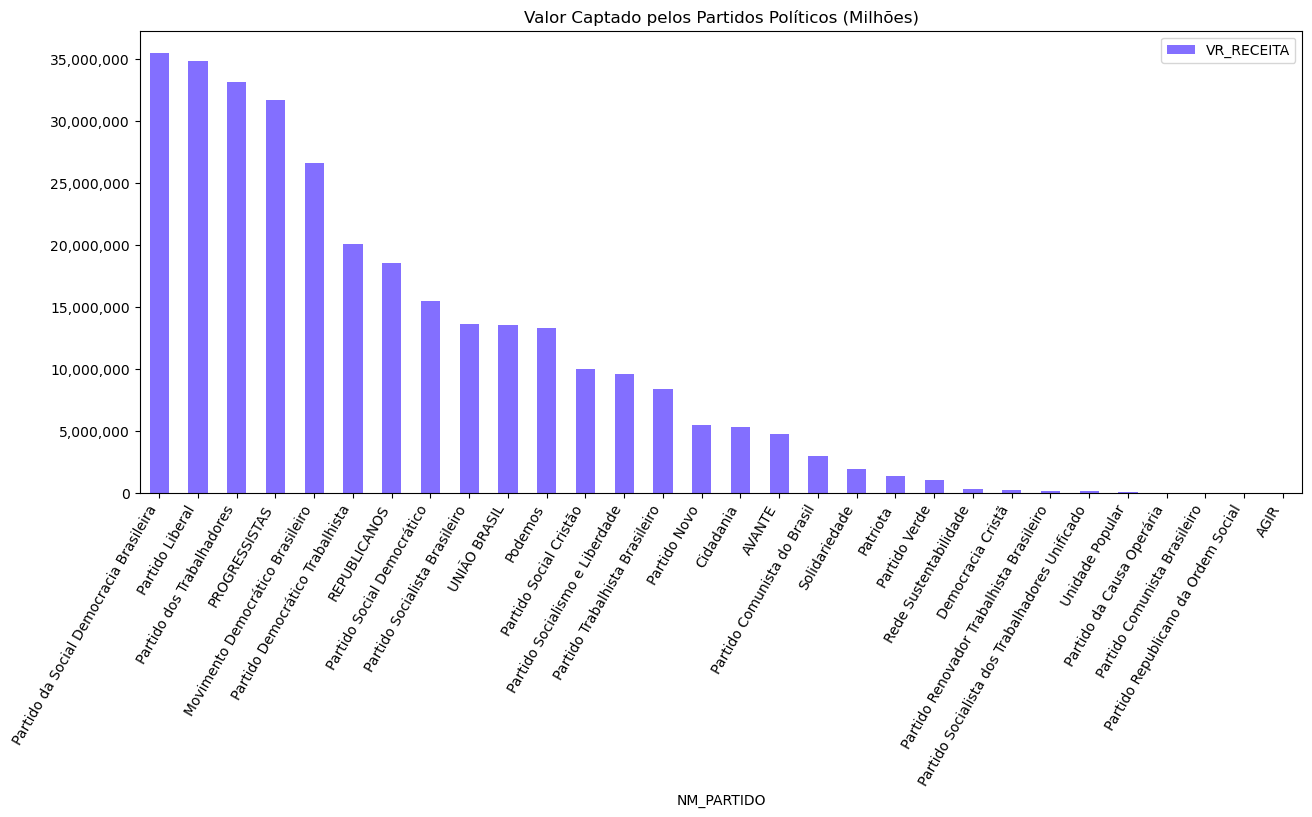

In [9]:
grupo = receitas[['NM_PARTIDO','VR_RECEITA']].groupby('NM_PARTIDO').sum().sort_values(by='VR_RECEITA', ascending=False)

fig, ax = plt.subplots(figsize=(15,6))
_ = grupo.plot.bar(ax=ax, color=slateBlue1)
plt.title('Valor Captado pelos Partidos Políticos (Milhões)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
ax.yaxis.set_major_formatter(formatter)

In [10]:
resposta = "******************************************************************************\n[RESPOSTA]:\n\n"
resposta = f"{resposta}O partido que mais captou recursos foi o {grupo.head(1).index[0]}, \n"
resposta = f"{resposta}Enquanto que o partido que menos captou foi o {grupo.tail(1).index[0]}."
resposta = f"{resposta}\n******************************************************************************\n"
print(resposta)

******************************************************************************
[RESPOSTA]:

O partido que mais captou recursos foi o Partido da Social Democracia Brasileira, 
Enquanto que o partido que menos captou foi o AGIR.
******************************************************************************



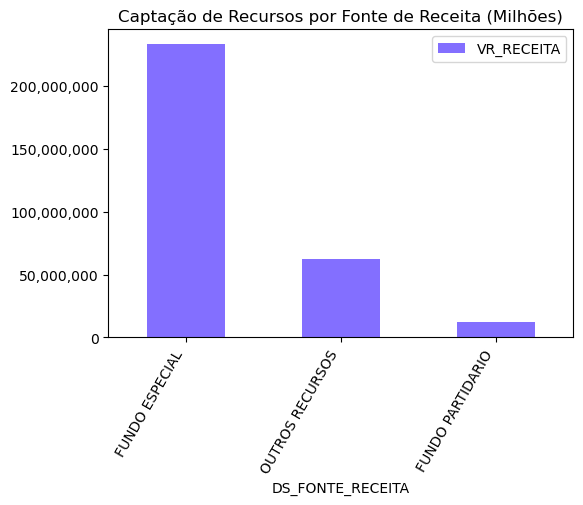

In [11]:
grupo = receitas[['DS_FONTE_RECEITA','VR_RECEITA']].groupby('DS_FONTE_RECEITA').sum().sort_values(by='VR_RECEITA', ascending=False)

fig, ax = plt.subplots(figsize=(6,4))
_ = grupo.plot.bar(ax=ax, color=slateBlue1)
_ = plt.title('Captação de Recursos por Fonte de Receita (Milhões)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
ax.yaxis.set_major_formatter(formatter)

In [12]:
resposta = "******************************************************************************\n[RESPOSTA]:\n\n"
resposta = f"{resposta}A maior fonte receita foi {grupo.head(1).index[0]}"
resposta = f"{resposta}\n******************************************************************************\n"
print(resposta)

******************************************************************************
[RESPOSTA]:

A maior fonte receita foi FUNDO ESPECIAL
******************************************************************************



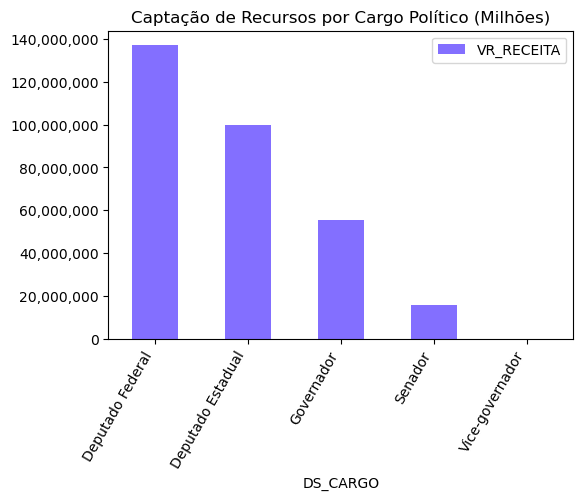

In [13]:
grupo = receitas[['DS_CARGO','VR_RECEITA']].groupby('DS_CARGO', observed=False).sum().sort_values(by='VR_RECEITA', ascending=False)

fig, ax = plt.subplots(figsize=(6,4))
_ = grupo.plot.bar(ax=ax, color=slateBlue1)
_ = plt.title('Captação de Recursos por Cargo Político (Milhões)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
ax.yaxis.set_major_formatter(formatter)

- **Resposta**
- Na visualização acima podemos ver as proporções de captação de recursos de acordo com os diferentes tipos de cargo político.

## 5. Algumas Frequências e Proporções

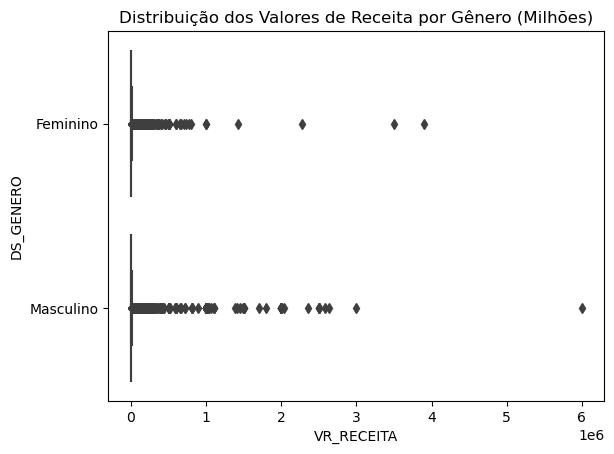

In [14]:
plt.title('Distribuição dos Valores de Receita por Gênero (Milhões)')
_ = sns.boxplot(y='DS_GENERO', x='VR_RECEITA', data=receitas)

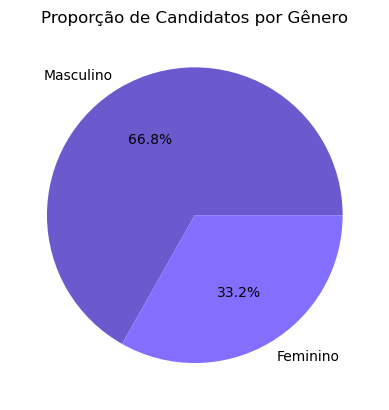

In [15]:
filtro_rec_masc = receitas[ receitas['DS_GENERO'] == 'Masculino' ]
filtro_rec_fem = receitas[ receitas['DS_GENERO'] == 'Feminino' ]
qtde_masc = len( filtro_rec_masc['NM_CANDIDATO'].unique() )
qtde_fem = len( filtro_rec_fem['NM_CANDIDATO'].unique() )

_ = plt.title('Proporção de Candidatos por Gênero')
_ = plt.pie([qtde_masc, qtde_fem],labels=['Masculino','Feminino'], autopct='%1.1f%%', colors=[slateBlue, slateBlue1])

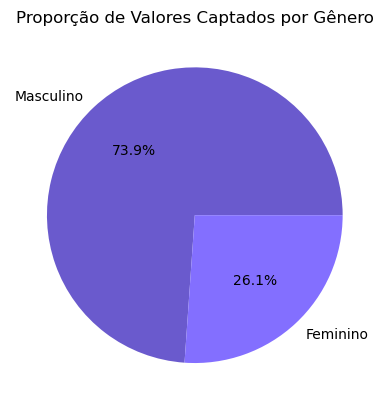

In [16]:
receitas_masc = filtro_rec_masc['VR_RECEITA'].sum()
receitas_fem = filtro_rec_fem['VR_RECEITA'].sum()

_ = plt.title('Proporção de Valores Captados por Gênero')
_ = plt.pie([receitas_masc, receitas_fem], labels=['Masculino','Feminino'], autopct='%1.1f%%', colors=[slateBlue, slateBlue1])

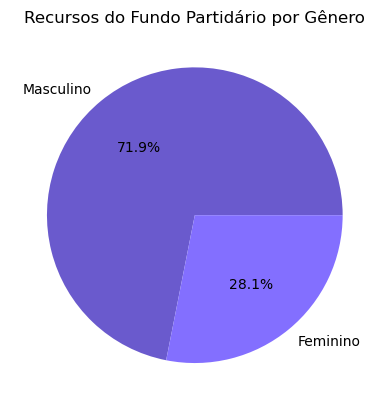

In [17]:
recurso_masc_fundopart = filtro_rec_masc[ filtro_rec_masc['DS_FONTE_RECEITA'] == 'FUNDO PARTIDARIO']['VR_RECEITA'].sum()
recurso_fem_fundopart = filtro_rec_fem[ filtro_rec_fem['DS_FONTE_RECEITA'] == 'FUNDO PARTIDARIO' ]['VR_RECEITA'].sum()

_ = plt.title('Recursos do Fundo Partidário por Gênero')
_ = plt.pie([recurso_masc_fundopart, recurso_fem_fundopart], labels=['Masculino','Feminino'], autopct='%1.1f%%', colors=[slateBlue, slateBlue1])

In [18]:
media_por_masc = recurso_masc_fundopart / qtde_masc
media_por_fem = recurso_fem_fundopart / qtde_fem

In [19]:
resposta = "******************************************************************************\n[RESPOSTA]:\n\n"
resposta = f"{resposta}A média distribuída a pelo Fundo Partidario aos candidatos de Gênero Masculino foi de {formatar_moeda(media_por_masc)}. \n"
resposta = f"{resposta}Por outro lado a média para candidatas foi de {formatar_moeda(media_por_fem)}"
resposta = f"{resposta}\n******************************************************************************\n"
print(resposta)

******************************************************************************
[RESPOSTA]:

A média distribuída a pelo Fundo Partidario aos candidatos de Gênero Masculino foi de R$ 9.330,88. 
Por outro lado a média para candidatas foi de R$ 7.342,57
******************************************************************************



- **Resposta**
- Ao observar as visualizações acima, constatamos que os candidatos masculinos possuem uma frequência de valores captados acima da média em relação às candidatas femininas. No entanto notamos que existe mais participação masculina do que feminina, onde 66,8% dos candidados tão masculinos 33,2% femininos. Com relação ao valor total de recursos captados, 73,9% foi captado por candidatos de gênero masculino, e 26,1%, pelo gênero fêminino.
- Importante destacar também que o próprio Fundo Partidário distribuiu em média menos recursos para candidatos do gênero feminino.

In [20]:
fund_part = receitas[ receitas['DS_FONTE_RECEITA'] == 'FUNDO PARTIDARIO' ]
dados_plot = fund_part[['DS_COR_RACA','VR_RECEITA']].groupby('DS_COR_RACA').sum().sort_values(by='VR_RECEITA', ascending=False)

info_raca = []

for r in fund_part['DS_COR_RACA'].unique():
    regs_r = fund_part[ fund_part['DS_COR_RACA'] == r ]
    valor = regs_r['VR_RECEITA'].sum()
    candidatos = len( regs_r['NM_CANDIDATO'].unique() )
    media = valor / candidatos

    info_raca.append({
        'raca':r,
        'valor':valor,
        'media':media
    })

df_info_raca = pd.DataFrame(info_raca)

display(df_info_raca)

,raca,valor,media
0,Branca,10385765.60,59347.232000
1,Parda,650265.95,40641.621875
2,Preta,578035.52,34002.089412
3,Indígena,403912.01,201956.005000


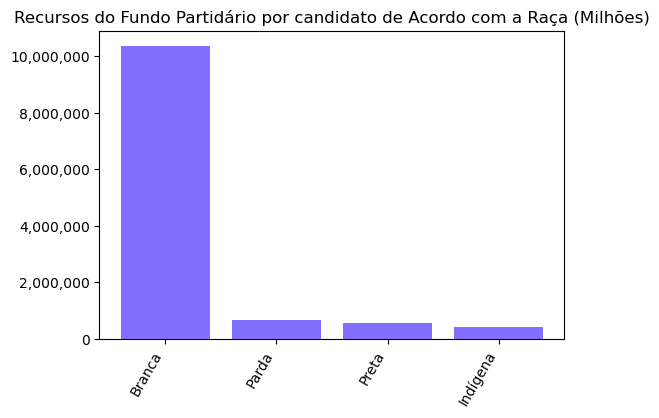

In [21]:
fig, ax = plt.subplots(figsize=(6,4))
_ = plt.bar(df_info_raca['raca'], df_info_raca['valor'], color=slateBlue1)
_ = plt.title('Recursos do Fundo Partidário por candidato de Acordo com a Raça (Milhões)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
ax.yaxis.set_major_formatter(formatter)

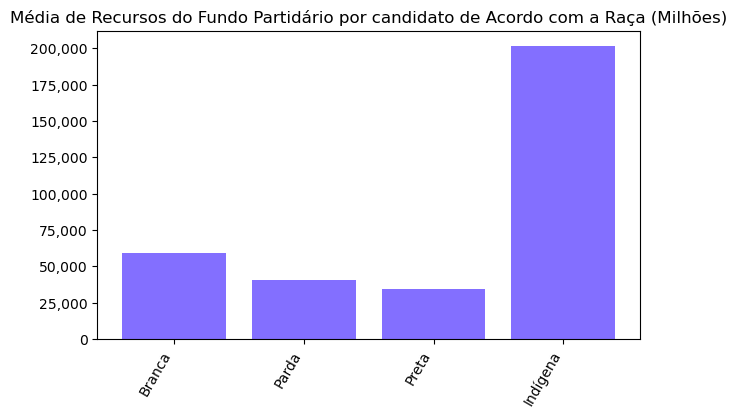

In [22]:
fig, ax = plt.subplots(figsize=(7,4))
_ = plt.bar(df_info_raca['raca'], df_info_raca['media'], color=slateBlue1)
_ = plt.title('Média de Recursos do Fundo Partidário por candidato de Acordo com a Raça (Milhões)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
ax.yaxis.set_major_formatter(formatter)

In [23]:
medias = df_info_raca['media'].tolist()
cv = variation(medias, axis=0)

In [24]:
msg_resposta = 'Não houve grandes variações'

if cv >= 0.5:
    msg_resposta = 'Houve grandes variações'
    
resposta = "******************************************************************************\n[RESPOSTA]:\n\n"
resposta = f"{resposta}O coeficiente de variação nas médias por candidato recebidas pelo Fundo Partidário foi de {cv},\n"
resposta = f"{resposta}indicando que {msg_resposta}.\n"
resposta = f"{resposta}Importante destacar que não adianta calcular o CV em cima dos valores recebidos por raça, \n"
resposta = f"{resposta}isso porque a quantidade de candidatos por raça parece estar impactando diretamente no valor total de receitas, \n"
resposta = f"{resposta}por isso, verificar o CV em cima das médias de distribuição do próprio fundo partidário parece mais sensato."
resposta = f"{resposta}\n******************************************************************************\n"
print(resposta)

******************************************************************************
[RESPOSTA]:

O coeficiente de variação nas médias por candidato recebidas pelo Fundo Partidário foi de 0.8184705080962674,
indicando que Houve grandes variações.
Importante destacar que não adianta calcular o CV em cima dos valores recebidos por raça, 
isso porque a quantidade de candidatos por raça parece estar impactando diretamente no valor total de receitas, 
por isso, verificar o CV em cima das médias de distribuição do próprio fundo partidário parece mais sensato.
******************************************************************************



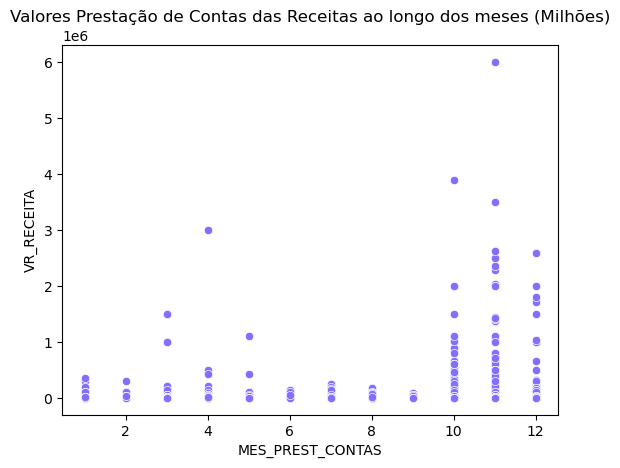

In [25]:
plt.title('Valores Prestação de Contas das Receitas ao longo dos meses (Milhões)')
_ = sns.scatterplot(y='VR_RECEITA', x='MES_PREST_CONTAS', data=receitas, color=slateBlue1)